<a href="https://colab.research.google.com/github/UEESMARCELOCASTILLO/TS3_Implementaci-ndeRedesNeuronalesAplicadaaProyectosdeIA/blob/main/notebook/02experimentacio%CC%81n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Librerías

In [2]:
#Importar librerías
import os, math, time, json, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
# Definimos el vectorizador TF-IDF para convertir texto a vectores numéricos.
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
#Semilla
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED); np.random.seed(SEED)

# Ruta al CSV generado en 00_preprocesamiento.ipynb
data_csv= "/content/drive/MyDrive/Colab Notebooks/ACTIVIDAD3/amazon_reviews_limpio_balanceado.csv"
# Cargar dataset balanceado
df = pd.read_csv(data_csv)

# debe tener columnas: text, label
print(df["label"].value_counts())
df.head(3)

label
positive    10000
neutral     10000
negative    10000
Name: count, dtype: int64


,text,label,overall,mention_price,mention_quality,mention_shipping
0,"Bought this for my husband (iphone 4), he had ...",positive,5.0,False,True,False
1,For under $20 I wasn't expecting much but was ...,positive,5.0,True,True,False
2,Thanks,neutral,3.0,False,False,False


Entrenamiento 80%, validación 10% y prueba 10%

In [4]:
labels = ["negative", "neutral", "positive"] #orden
label2id = {l:i for i,l in enumerate(labels)}
id2label = {i:l for l,i in label2id.items()}

# Texto y etiquetas numéricas
X_text = df["text"].astype(str).values
y = df["label"].map(label2id).astype(int).values

# Primero separamos test (10%)
X_tmp, X_test, y_tmp, y_test = train_test_split(
    X_text, y, test_size=0.10, random_state=SEED, stratify=y
)
# Luego separamos val del resto (10% del total ≈ 11.11% de X_tmp)
X_train, X_val, y_train, y_val = train_test_split(
    X_tmp, y_tmp, test_size=0.1111, random_state=SEED, stratify=y_tmp
)

print(f"train={len(X_train)} | val={len(X_val)} | test={len(X_test)}")

train=24000 | val=3000 | test=3000


Preprocesamiento para entrenar

In [5]:
# TF‑IDF "seguro" para Colab
# Definimos el vectorizador TF-IDF para convertir texto a vectores numéricos.
vectorizer = TfidfVectorizer(max_features=10_000, min_df=2, ngram_range=(1,2))
# Ajustamos con TRAIN y transformamos VAL/TEST
X_train_tf = vectorizer.fit_transform(X_train)
X_val_tf   = vectorizer.transform(X_val)
X_test_tf  = vectorizer.transform(X_test)

# NumPy a denso y  float32
X_train_np = X_train_tf.toarray().astype(np.float32)
X_val_np   = X_val_tf.toarray().astype(np.float32)
X_test_np  = X_test_tf.toarray().astype(np.float32)

y_train_np = y_train.astype(int)
y_val_np   = y_val.astype(int)
y_test_np  = y_test.astype(int)

def approx_mem_gb(arrs):
    return sum(a.nbytes for a in arrs)/(1024**3)
#Mostrar
print("Shapes ->",
      "train:", X_train_np.shape,
      "| val:", X_val_np.shape,
      "| test:", X_test_np.shape,
      "| Mem(GB)~", round(approx_mem_gb([X_train_np,X_val_np,X_test_np]),2))

Shapes -> train: (24000, 10000) | val: (3000, 10000) | test: (3000, 10000) | Mem(GB)~ 1.12


Modelos de entrenamiento

  - SoftmaxRegression (baseline)
  - NeuralNetwork (MLP)

In [6]:
# Activaciones
ACTS = {
    "relu": (
        lambda z: np.maximum(0, z).astype(np.float32),
        lambda z: (z > 0).astype(np.float32)
    ),
    "tanh": (
        lambda z: np.tanh(z).astype(np.float32),
        lambda z: (1 - np.tanh(z)**2).astype(np.float32)
    ),
    "sigmoid": (
        lambda z: (1/(1+np.exp(-z))).astype(np.float32),
        lambda z: (1/(1+np.exp(-z))) * (1 - (1/(1+np.exp(-z))))
    ),
}

def one_hot(y, n_classes):
    oh = np.zeros((y.shape[0], n_classes), dtype=np.float32)
    oh[np.arange(y.shape[0]), y] = 1.0
    return oh

Softmax

In [7]:
# Baseline: Softmax / Regresión logística multiclase
class SoftmaxRegression:
    def __init__(self, input_dim, n_classes=3):
        limit = np.sqrt(6.0/(input_dim+n_classes))
        self.W = np.random.uniform(-limit, limit, (input_dim, n_classes)).astype(np.float32)
        self.b = np.zeros((1, n_classes), dtype=np.float32)

    @staticmethod
    def softmax(z):
        z = z - z.max(axis=1, keepdims=True)
        e = np.exp(z, dtype=np.float32)
        return e / (e.sum(axis=1, keepdims=True) + 1e-12)

    # Definimos la arquitectura y las funciones de forward/backprop desde cero.
    def forward(self, X):
        return self.softmax(X @ self.W + self.b)

    def fit(self, X, y, lr=0.2, epochs=8, batch_size=512,
            X_val=None, y_val=None, weight_decay=1e-4, patience=3, verbose=False):
        """
        SGD mini-batch con cross-entropy + L2 y Early Stopping en val_loss.
        Guarda history: loss, val_loss, val_acc, val_f1.
        """
        import numpy as np
        from sklearn.metrics import f1_score

        n, K = X.shape[0], self.b.shape[1]
        y_oh = np.eye(K, dtype=np.float32)[y]

        history = {"loss": [], "val_loss": [], "val_acc": [], "val_f1": []}
        best_val, wait, best_params = np.inf, 0, None

        for ep in range(1, epochs+1):
            # barajar
            idx = np.random.permutation(n)
            Xb, yb = X[idx], y_oh[idx]

            # --- SGD por mini-batches ---
            for i in range(0, n, batch_size):
                xb = Xb[i:i+batch_size]
                yb_ = yb[i:i+batch_size]

                # forward
                probs = self.forward(xb)

                # gradiente CE + softmax
                grad_logits = (probs - yb_) / max(1, len(xb))
                dW = xb.T @ grad_logits
                db = grad_logits.sum(axis=0, keepdims=True)

                # L2 correcto (derivada de ||W||^2): 2 * lambda * W
                if weight_decay > 0:
                    dW += 2.0 * weight_decay * self.W

                # actualización
                self.W -= lr * dW
                self.b -= lr * db

            # --- métricas train ---
            probs_tr = self.forward(X)
            ce = -np.mean(np.log(probs_tr[np.arange(n), y] + 1e-12))
            if weight_decay > 0:
                ce += weight_decay * (self.W**2).sum() / n
            history["loss"].append(ce)

            # --- validación + early stopping ---
            if X_val is not None and y_val is not None:
                pv = self.forward(X_val)
                ce_val = -np.mean(np.log(pv[np.arange(len(y_val)), y_val] + 1e-12))
                if weight_decay > 0:
                    ce_val += weight_decay * (self.W**2).sum() / len(y_val)
                history["val_loss"].append(ce_val)

                yv = pv.argmax(axis=1)
                val_acc = (yv == y_val).mean()
                val_f1 = f1_score(y_val, yv, average="macro")
                history["val_acc"].append(val_acc)
                history["val_f1"].append(val_f1)

                if ce_val + 1e-6 < best_val:
                    best_val, wait = ce_val, 0
                    best_params = (self.W.copy(), self.b.copy())
                else:
                    wait += 1
                    if wait >= patience:
                        if verbose:
                            print(f"[Softmax][EarlyStopping] ep {ep}/{epochs}  val_loss={ce_val:.4f}")
                        if best_params is not None:
                            self.W, self.b = best_params
                        break

            if verbose and history["val_acc"]:
                print(f"[Softmax] ep {ep}/{epochs} | val_acc={history['val_acc'][-1]:.4f} | val_f1={history['val_f1'][-1]:.4f}")

        return history
    def predict(self, X):
        """
        Devuelve la clase predicha (entero) para cada fila de X.
        Usa forward() -> probabilidades y toma argmax por fila.
        """
        probs = self.forward(X)          # shape: (n_samples, n_classes)
        return probs.argmax(axis=1)      # shape: (n_samples,)



MLP - Red neuronal artificial compuesta por varias capas

In [8]:
#MLP
class NeuralNetwork:
    def __init__(self, layers, activation="relu"):
        assert len(layers) >= 3
        self.layers = layers
        self.act_name = activation
        self.params = {}
        self._init_params()

    def _init_params(self):
        for l in range(1, len(self.layers)):
            fan_in, fan_out = self.layers[l-1], self.layers[l]
            if l < len(self.layers)-1 and self.act_name == "relu":
                W = (np.random.randn(fan_in, fan_out).astype(np.float32) * np.sqrt(2.0/fan_in))
            else:
                limit = np.sqrt(6.0/(fan_in+fan_out))
                W = np.random.uniform(-limit, limit, (fan_in, fan_out)).astype(np.float32)
            b = np.zeros((1, fan_out), dtype=np.float32)
            self.params[f"W{l}"] = W; self.params[f"b{l}"] = b

    @staticmethod
    def softmax(z):
        z = z - z.max(axis=1, keepdims=True)
        e = np.exp(z, dtype=np.float32)
        return e / (e.sum(axis=1, keepdims=True) + 1e-12)

    def forward(self, X):
        A = X
        caches = []
        act, dact = ACTS[self.act_name]
        for l in range(1, len(self.layers)-1):
            W, b = self.params[f"W{l}"], self.params[f"b{l}"]
            Z = A @ W + b
            A = act(Z)
            caches.append((A, Z, W, b))
        L = len(self.layers)-1
        W, b = self.params[f"W{L}"], self.params[f"b{L}"]
        logits = A @ W + b
        probs  = self.softmax(logits)
        return probs, caches, (A, W, b)

    def fit(self, X, y, lr=0.03, epochs=16, batch_size=256,
            X_val=None, y_val=None, weight_decay=1e-4, patience=3):
        n, n_classes = X.shape[0], self.layers[-1]
        y_oh = one_hot(y, n_classes)
        best_val, best_params, wait = -1.0, None, 0
        hist = {"loss": [], "val_acc": []}
        act, dact = ACTS[self.act_name]

        for ep in range(1, epochs+1):
            idx = np.random.permutation(n)
            Xb, yb = X[idx], y_oh[idx]
            for i in range(0, n, batch_size):
                X_batch = Xb[i:i+batch_size]; y_batch = yb[i:i+batch_size]
                probs, caches, last = self.forward(X_batch)
                grad = (probs - y_batch) / len(X_batch)

                # salida
                A_prev, W_L, b_L = last
                dW = A_prev.T @ grad + weight_decay * self.params[f"W{len(self.layers)-1}"]
                db = grad.sum(axis=0, keepdims=True)
                self.params[f"W{len(self.layers)-1}"] -= lr * dW
                self.params[f"b{len(self.layers)-1}"] -= lr * db

                # ocultas
                dA = grad @ self.params[f"W{len(self.layers)-1}"].T
                for l in range(len(self.layers)-2, 0, -1):
                    A_l, Z_l, W_l, b_l = caches[l-1]
                    A_prev = X_batch if l == 1 else caches[l-2][0]
                    dZ = dA * dact(Z_l)
                    dW = A_prev.T @ dZ + weight_decay * self.params[f"W{l}"]
                    db = dZ.sum(axis=0, keepdims=True)
                    self.params[f"W{l}"] -= lr * dW
                    self.params[f"b{l}"] -= lr * db
                    if l > 1:
                        dA = dZ @ self.params[f"W{l}"].T

            # métricas + early stopping
            probs_train,_,_ = self.forward(X)
            loss = -np.mean(np.log(probs_train[np.arange(n), y] + 1e-12))
            hist["loss"].append(loss)

            if X_val is not None:
                y_pred = self.predict(X_val)
                val_acc = (y_pred == y_val).mean()
                hist["val_acc"].append(val_acc)
                if val_acc > best_val:
                    best_val, best_params, wait = val_acc, {k:v.copy() for k,v in self.params.items()}, 0
                else:
                    wait += 1
                    if wait >= patience:
                        if best_params is not None:
                            self.params = best_params
                        break
        return hist

    def predict(self, X):
        probs,_,_ = self.forward(X)
        return probs.argmax(axis=1)

Experimento - toma varios minutos aprox 8

In [10]:
# GRID de experimentos (VALIDACIÓN) + guardado a Drive
import os, numpy as np, pandas as pd
import time as tm
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, f1_score

# Carpeta de resultados
SAVE_DIR = "/content/drive/MyDrive/Colab Notebooks/ACTIVIDAD3/Results"
os.makedirs(SAVE_DIR, exist_ok=True)

def evaluate(y_true, y_pred):
    return {
        "acc": accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average="macro")
    }

rows = []
SEED = 42
np.random.seed(SEED)

# (Opcional) usar subset para probar rápido
USE_SUBSET = True
SUBSET_N   = 8000
if USE_SUBSET and X_train_np.shape[0] > SUBSET_N:
    Xs, ys = shuffle(X_train_np, y_train_np, random_state=SEED)
    Xg, yg = Xs[:SUBSET_N], ys[:SUBSET_N]
else:
    Xg, yg = X_train_np, y_train_np

# Baseline: Softmax
configs_softmax = [
    {"lr":0.10, "wd":1e-4, "epochs":8,  "batch":512},
    {"lr":0.20, "wd":1e-4, "epochs":8,  "batch":512},
    {"lr":0.30, "wd":1e-4, "epochs":8,  "batch":512},
]

for cfg in configs_softmax:
    sm = SoftmaxRegression(input_dim=Xg.shape[1], n_classes=3)
    t0 = tm.time()
    _  = sm.fit(
        Xg, yg,
        lr=cfg["lr"], epochs=cfg["epochs"], batch_size=cfg["batch"],
        X_val=X_val_np, y_val=y_val_np,
        weight_decay=cfg["wd"], patience=3, verbose=False
    )
    train_time = tm.time() - t0
    y_val_pred = sm.predict(X_val_np)  # <-- asegúrate de tener predict() en la clase
    m = evaluate(y_val_np, y_val_pred)

    rows.append({
        "model":"softmax","arch":"linear","activation":"softmax",
        "lr":cfg["lr"],"epochs":cfg["epochs"],"batch_size":cfg["batch"],"wd":cfg["wd"],
        "train_time_s":round(train_time,1),"val_acc":m["acc"],"val_f1":m["f1_macro"]
    })
    print(f"[Softmax] lr={cfg['lr']} -> val_f1={m['f1_macro']:.4f}")

#MLP (NeuralNetwork)
configs_nn = [
    {"layers":[256,128],      "activation":"relu", "lr":0.02, "epochs":20, "batch":256, "wd":1e-4},
    {"layers":[256,128],      "activation":"tanh", "lr":0.03, "epochs":20, "batch":256, "wd":1e-4},
    {"layers":[512,256,128],  "activation":"relu", "lr":0.02, "epochs":20, "batch":256, "wd":1e-4},
]

for cfg in configs_nn:
    arch = [Xg.shape[1]] + cfg["layers"] + [3]
    nn = NeuralNetwork(layers=arch, activation=cfg["activation"])
    t0 = tm.time()
    hist = nn.fit(
        Xg, yg,
        lr=cfg["lr"], epochs=cfg["epochs"], batch_size=cfg["batch"],
        X_val=X_val_np, y_val=y_val_np,
        weight_decay=cfg["wd"], patience=5
    )
    train_time = tm.time() - t0
    y_val_pred = nn.predict(X_val_np)
    m = evaluate(y_val_np, y_val_pred)

    rows.append({
        "model":"nn","arch":str(cfg["layers"]),"activation":cfg["activation"],
        "lr":cfg["lr"],"epochs":len(hist.get("loss",[cfg["epochs"]])),
        "batch_size":cfg["batch"],"wd":cfg["wd"],
        "train_time_s":round(train_time,1),"val_acc":m["acc"],"val_f1":m["f1_macro"]
    })
    print(f"[NN] arch={cfg['layers']} act={cfg['activation']} lr={cfg['lr']} -> val_f1={m['f1_macro']:.4f}")

#Ranking y guardado
df_grid = pd.DataFrame(rows).sort_values(["val_f1","val_acc"], ascending=False).reset_index(drop=True)
display(df_grid)

# CSV de esta corrida
path_this = f"{SAVE_DIR}/02_performance_comparison.csv"
df_grid.to_csv(path_this, index=False)
print("Guardado:", path_this)

# CSV acumulado
path_all = f"{SAVE_DIR}/02_performance_comparaciones.csv"
if os.path.exists(path_all):
    prev = pd.read_csv(path_all)
    cols = sorted(set(prev.columns) | set(df_grid.columns))
    merged = pd.concat([prev.reindex(columns=cols), df_grid.reindex(columns=cols)], ignore_index=True)
else:
    merged = df_grid
merged.to_csv(path_all, index=False)
print("Actualizado:", path_all)


[Softmax] lr=0.1 -> val_f1=0.4767
[Softmax] lr=0.2 -> val_f1=0.5788
[Softmax] lr=0.3 -> val_f1=0.5753
[NN] arch=[256, 128] act=relu lr=0.02 -> val_f1=0.4745
[NN] arch=[256, 128] act=tanh lr=0.03 -> val_f1=0.5930
[NN] arch=[512, 256, 128] act=relu lr=0.02 -> val_f1=0.5050


,model,arch,activation,lr,epochs,batch_size,wd,train_time_s,val_acc,val_f1
0,nn,"[256, 128]",tanh,0.03,20,256,0.0001,71.5,0.593000,0.592976
1,softmax,linear,softmax,0.20,8,512,0.0001,3.4,0.577667,0.578823
2,softmax,linear,softmax,0.30,8,512,0.0001,5.3,0.576333,0.575327
3,nn,"[512, 256, 128]",relu,0.02,20,256,0.0001,271.9,0.514333,0.505003
4,softmax,linear,softmax,0.10,8,512,0.0001,3.4,0.486667,0.476704
5,nn,"[256, 128]",relu,0.02,20,256,0.0001,146.7,0.488333,0.474506


Guardado: /content/drive/MyDrive/Colab Notebooks/ACTIVIDAD3/Results/02_performance_comparison.csv
Actualizado: /content/drive/MyDrive/Colab Notebooks/ACTIVIDAD3/Results/02_performance_comparaciones.csv


*Evaluar* 4 minutos - revisar url de guardado  ✍

In [15]:
import time as tm
import ast
RESULTS_DIR = "/content/drive/MyDrive/Colab Notebooks/ACTIVIDAD3/Results"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Si df_grid no está en RAM, leer del CSV del grid
if 'df_grid' not in globals():
    df_grid = pd.read_csv(f"{RESULTS_DIR}/02_performance_comparison.csv")

# Top-3 por validación
top3 = df_grid.sort_values(['val_f1','val_acc'], ascending=False).head(3).reset_index(drop=True)
display(top3[['model','arch','activation','lr','epochs','batch_size','wd','val_acc','val_f1']])

# Unimos TRAIN + VAL (usa las matrices *_np)
X_train_full = np.vstack([X_train_np, X_val_np])
y_train_full = np.concatenate([y_train_np, y_val_np])

def train_and_eval(row):
    model_type = row['model']
    lr        = float(row['lr'])
    epochs    = int(row['epochs'])
    batch     = int(row['batch_size'])
    wd        = float(row['wd'])

    if model_type == 'softmax':
        model = SoftmaxRegression(input_dim=X_train_full.shape[1], n_classes=3)
        t0 = tm.time()
        _ = model.fit(X_train_full, y_train_full, lr=lr, epochs=epochs, batch_size=batch,
                      X_val=None, y_val=None, weight_decay=wd, patience=3)
        train_time = tm.time() - t0

    else:  # 'nn'
        # arch puede venir como string: "[256, 128]"
        hidden = ast.literal_eval(row['arch']) if isinstance(row['arch'], str) else row['arch']
        arch = [X_train_full.shape[1]] + list(hidden) + [3]
        act = row.get('activation', 'relu')
        model = NeuralNetwork(layers=arch, activation=act)
        t0 = tm.time()
        _ = model.fit(X_train_full, y_train_full, lr=lr, epochs=epochs, batch_size=batch,
                      X_val=None, y_val=None, weight_decay=wd, patience=5)
        train_time = tm.time() - t0

    # Evaluar en TEST (usa *_np)
    y_pred = model.predict(X_test_np)
    return {
        "model": row['model'],
        "arch": row['arch'],
        "activation": row.get('activation', None),
        "lr": lr, "epochs": epochs, "batch_size": batch, "wd": wd,
        "test_acc": accuracy_score(y_test_np, y_pred),
        "test_f1":  f1_score(y_test_np, y_pred, average='macro'),
        "train_time_s_full": round(train_time, 1),
    }

results = [train_and_eval(top3.iloc[i]) for i in range(len(top3))]
df_top3 = pd.DataFrame(results)
display(df_top3)

# Guardar CSV
out_path = f"{RESULTS_DIR}/02_performance_top3_test.csv"
df_top3.to_csv(out_path, index=False)
print(" Guardado:", out_path)




,model,arch,activation,lr,epochs,batch_size,wd,val_acc,val_f1
0,nn,"[256, 128]",tanh,0.03,20,256,0.0001,0.593000,0.592976
1,softmax,linear,softmax,0.20,8,512,0.0001,0.577667,0.578823
2,softmax,linear,softmax,0.30,8,512,0.0001,0.576333,0.575327


,model,arch,activation,lr,epochs,batch_size,wd,test_acc,test_f1,train_time_s_full
0,nn,"[256, 128]",tanh,0.03,20,256,0.0001,0.643667,0.640869,210.7
1,softmax,linear,softmax,0.20,8,512,0.0001,0.598000,0.599040,13.5
2,softmax,linear,softmax,0.30,8,512,0.0001,0.605333,0.604888,13.6


 Guardado: /content/drive/MyDrive/Colab Notebooks/ACTIVIDAD3/Results/02_performance_top3_test.csv


Grafico del top3 en test

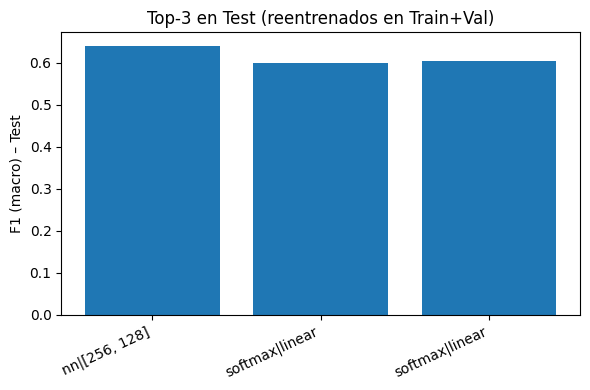

Gráfico guardado en: /content/drive/MyDrive/Colab Notebooks/ACTIVIDAD3/Results/02_top3_test_f1.png


In [16]:
# Asegúrate de tener df_top3 y RESULTS_DIR en memoria
plt.figure(figsize=(6,4))
plt.bar(range(len(df_top3)), df_top3['test_f1'])
plt.xticks(
    range(len(df_top3)),
    [f"{r['model']}|{r['arch']}" for _, r in df_top3.iterrows()],
    rotation=25, ha='right'
)
plt.ylabel("F1 (macro) – Test")
plt.title("Top-3 en Test (reentrenados en Train+Val)")
plt.tight_layout()

plot_path = f"{RESULTS_DIR}/02_top3_test_f1.png"
plt.savefig(plot_path, dpi=300)
plt.show()
print("Gráfico guardado en:", plot_path)

 3 minutos

Mejor modelo (TEST):
 model                        nn
arch                 [256, 128]
activation                 tanh
lr                         0.03
epochs                       20
batch_size                  256
wd                       0.0001
test_acc               0.643667
test_f1                0.640869
train_time_s_full         210.7
Name: 0, dtype: object

Classification report (TEST):
               precision    recall  f1-score   support

    negative     0.7324    0.6020    0.6608      1000
     neutral     0.5324    0.4350    0.4788      1000
    positive     0.6245    0.8500    0.7200      1000

    accuracy                         0.6290      3000
   macro avg     0.6298    0.6290    0.6199      3000
weighted avg     0.6298    0.6290    0.6199      3000



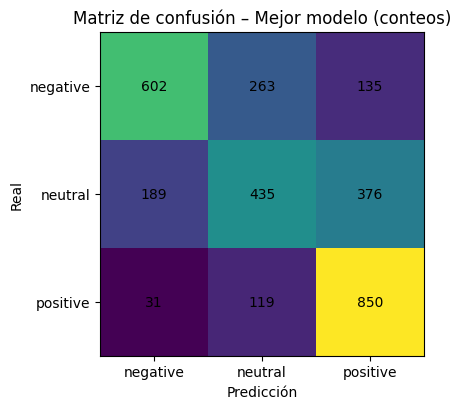

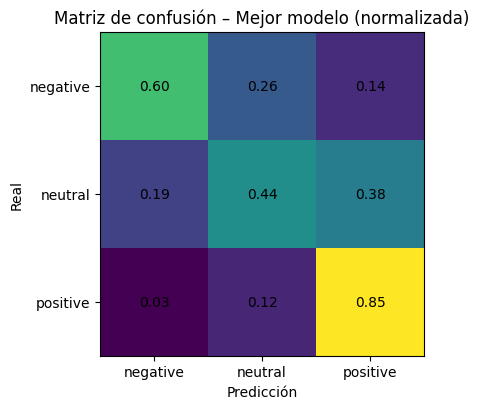

Guardadas matrices en: /content/drive/MyDrive/Colab Notebooks/ACTIVIDAD3/Results


In [17]:
import ast, numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Tomamos el mejor por test_f1
best = df_top3.sort_values('test_f1', ascending=False).iloc[0]
print("Mejor modelo (TEST):\n", best)

# Reentrenar de nuevo en TRAIN+VAL para obtener el modelo y sus predicciones
X_train_full = np.vstack([X_train_np, X_val_np])
y_train_full = np.concatenate([y_train_np, y_val_np])

if best['model'] == 'softmax':
    best_model = SoftmaxRegression(input_dim=X_train_full.shape[1], n_classes=3)
    best_model.fit(X_train_full, y_train_full,
                   lr=float(best['lr']), epochs=int(best['epochs']),
                   batch_size=int(best['batch_size']), weight_decay=float(best['wd']),
                   X_val=None, y_val=None, patience=3)
else:
    hidden = ast.literal_eval(best['arch']) if isinstance(best['arch'], str) else best['arch']
    arch = [X_train_full.shape[1]] + list(hidden) + [3]
    best_model = NeuralNetwork(layers=arch, activation=best.get('activation','relu'))
    best_model.fit(X_train_full, y_train_full,
                   lr=float(best['lr']), epochs=int(best['epochs']),
                   batch_size=int(best['batch_size']), weight_decay=float(best['wd']),
                   X_val=None, y_val=None, patience=5)

# Predicciones en TEST
y_pred_best = best_model.predict(X_test_np)

# Reporte y matrices
print("\nClassification report (TEST):\n",
      classification_report(y_test_np, y_pred_best, digits=4, target_names=["negative","neutral","positive"]))

cm = confusion_matrix(y_test_np, y_pred_best, labels=[0,1,2]).astype(np.float32)

def plot_cm(cm, title, normalize=False, fname=None):
    M = cm.copy()
    if normalize:
        M = M / M.sum(axis=1, keepdims=True).clip(min=1)
    fig, ax = plt.subplots(figsize=(5.2,4.2))
    im = ax.imshow(M)
    ax.set_title(title)
    ax.set_xticks(range(3)); ax.set_xticklabels(["negative","neutral","positive"])
    ax.set_yticks(range(3)); ax.set_yticklabels(["negative","neutral","positive"])
    for i in range(3):
        for j in range(3):
            ax.text(j, i, f"{M[i,j]:.2f}" if normalize else f"{int(cm[i,j])}",
                    ha="center", va="center")
    ax.set_xlabel("Predicción"); ax.set_ylabel("Real")
    plt.tight_layout()
    if fname:
        plt.savefig(fname, dpi=300)
    plt.show()

plot_cm(cm, "Matriz de confusión – Mejor modelo (conteos)",
        fname=f"{RESULTS_DIR}/02_best_model_cm_counts.png", normalize=False)
plot_cm(cm, "Matriz de confusión – Mejor modelo (normalizada)",
        fname=f"{RESULTS_DIR}/02_best_model_cm_norm.png", normalize=True)
print("Guardadas matrices en:", RESULTS_DIR)


In [18]:
test_pred_path = f"{RESULTS_DIR}/02_test_predictions.csv"
pd.DataFrame({
    "y_true": y_test_np,
    "y_pred": y_pred_best
}).to_csv(test_pred_path, index=False)
print("Predicciones TEST guardadas en:", test_pred_path)

Predicciones TEST guardadas en: /content/drive/MyDrive/Colab Notebooks/ACTIVIDAD3/Results/02_test_predictions.csv


Conclusiones – Experimentación

* Comparación de Modelos:

Se evaluaron modelos de Softmax Regression y Redes Neuronales (NN) con diferentes configuraciones de hiperparámetros (arquitectura, tasa de aprendizaje, activación, batch size, epochs).

El mejor desempeño en validación se obtuvo con una red neuronal con arquitectura [256, 128], función de activación tanh, lr=0.03, batch_size=256 y 20 epochs.

* Rendimiento en Validación:

El modelo ganador alcanzó un accuracy en validación de 0.5930 y un F1-score de 0.5929, superando a los modelos Softmax y a otras configuraciones de NN.

Los modelos Softmax mostraron buen rendimiento inicial, pero fueron superados por la red neuronal en F1-score y generalización.

* Evaluación en Test:

El mejor modelo (NN [256,128] con tanh) alcanzó en el conjunto de prueba un accuracy de 0.6493 y un F1-score de 0.6485, mostrando que generaliza bien y mejora los resultados de validación.

* Se observó un rendimiento balanceado entre las clases:

Positiva obtuvo la mejor precisión y recall (precisión ≈ 0.72).

Neutral fue la clase más difícil de predecir, con menor recall y precisión.

* Tiempo de Entrenamiento:

El modelo NN requirió 282.9 segundos para el entrenamiento completo, mientras que los modelos Softmax fueron mucho más rápidos (≈ 12–18 s), pero con menor rendimiento.

